In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ruptures as rpt

from sklearn import linear_model
from sklearn.metrics import mean_squared_error

### Detecting Change Points on the global CO2 dataset

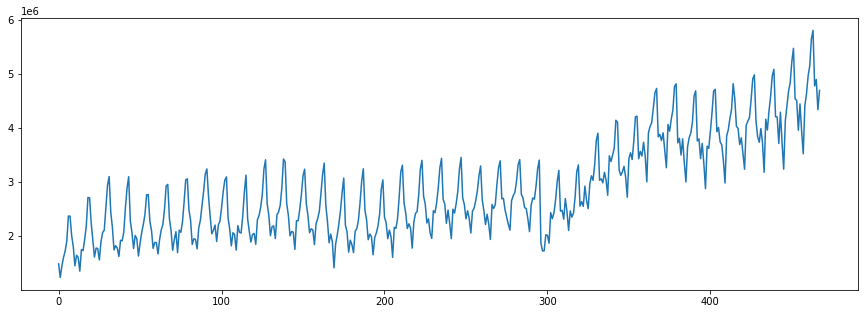

In [3]:
jfk = pd.read_csv("/home/aumaron/Desktop/other_projects/datasets/time_series/jfk_passengers.csv")
plt.figure(figsize=(15,5))
plt.plot(jfk["t"], jfk["Number of Passengers"])

In [5]:
import math
from scipy import signal
frequency, amplitude = signal.periodogram(x=jfk['Number of Passengers'].values, detrend='linear')
frequency_with_max_amp = frequency[amplitude.argmax()]
seasonality = math.ceil(1 / frequency_with_max_amp)
print(seasonality)

12


In [17]:
def get_changepoints(signal , minimum_size=10):

    linear_signal = np.column_stack((signal, np.ones(signal.shape[0]), np.linspace(1, signal.shape[0], signal.shape[0])))
    ar_cost = rpt.costs.CostLinear()
    # detection
    algo = rpt.Pelt(custom_cost=ar_cost, min_size=minimum_size).fit(linear_signal)
    result = algo.predict(pen=np.log(signal.shape[0])*2)

    # display
    rpt.display(signal, result)
    plt.show()
    
    return linear_signal, result
    
def regression_between_points(signal, 
                              lower_limit, 
                              upper_limit):
    # Linear Regression
    signal_to_fit = signal[lower_limit: upper_limit]
    model = linear_model.LinearRegression()
    target = signal_to_fit[:, 0]
    features = signal_to_fit[:, 1:]
    model.fit(features, target)
    predict = model.predict(features)
    coef = model.coef_
    mean = np.mean(target)
    growth = (target[-1] - target[0])/ target[0] * 100.0
        
    return predict, coef, mean, growth

### Detecting Change Points on the JFK dataset

Checking for various min_sizes and order=3

In [10]:
jfk[:22]

,Unnamed: 0,t,Number of Passengers
0,0,0,1487588.0
1,1,1,1237719.0
2,2,2,1450395.0
3,3,3,1609159.0
4,4,4,1724392.0
5,5,5,1906396.0
6,6,6,2373334.0
7,7,7,2372987.0
8,8,8,2010979.0
9,9,9,1806198.0


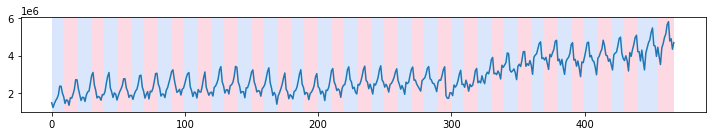

BreakPoints for min_size 10.0 ->  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 455, 468]


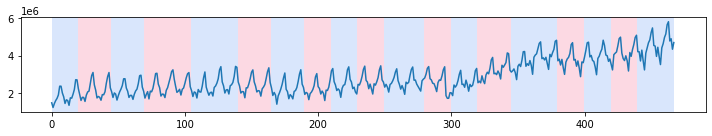

BreakPoints for min_size 20.0 ->  [20, 45, 70, 105, 140, 165, 190, 210, 230, 250, 280, 300, 320, 345, 380, 400, 420, 440, 468]


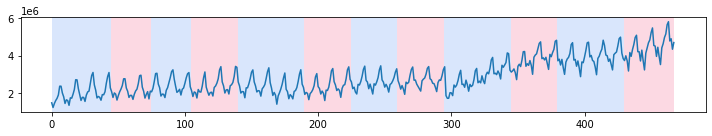

BreakPoints for min_size 30.0 ->  [45, 75, 105, 140, 190, 225, 260, 295, 345, 380, 430, 468]


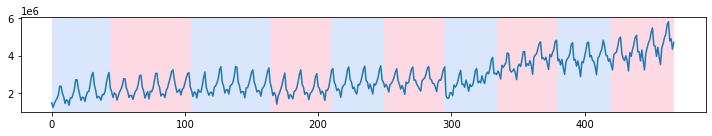

BreakPoints for min_size 40.0 ->  [45, 105, 165, 210, 250, 295, 335, 380, 420, 468]


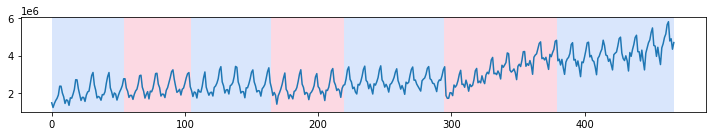

BreakPoints for min_size 50.0 ->  [55, 105, 165, 220, 295, 380, 468]


In [4]:
for _size in np.linspace(10, 50, 5):
    sig, result = get_changepoints(signal = jfk["Number of Passengers"].values,
                                   minimum_size=_size)
    print(f"BreakPoints for min_size {_size} -> ", result)

### Heuristics for JFK

After a visual assessment finalising min_size as 50

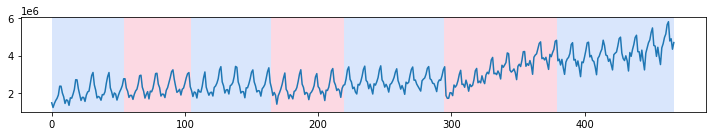

[55, 105, 165, 220, 295, 380, 468]

In [19]:
# min_size=50
lin_sig, change_points = get_changepoints(signal=jfk["Number of Passengers"].values, minimum_size=50)
change_points


ValueError: too many values to unpack (expected 3)

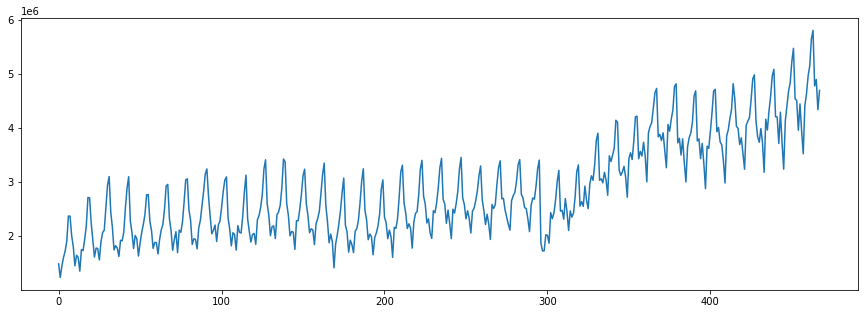

In [20]:
# Fitting regression lines between change points
plt.figure(figsize=(15,5))
plt.plot(jfk["t"], jfk["Number of Passengers"])

predi = {}
mse_ = {}
prev_change = 0
for i, each_change_point in enumerate(change_points):
    if prev_change == 0:
        coef, mean, growth = regression_between_points(signal=lin_sig, lower_limit=prev_change, upper_limit=each_change_point)
        predi.update({f"pred{i}": pred})
        plt.plot(lin_sig[:each_change_point, 2], pred)
        print(f"Coefficient for {prev_change} to {each_change_point} -> {coef[1]}")
#         print(f"Angle for {prev_change} to {each_change_point} -> {np.arctan(coef)*180/np.pi}")
#         print(f"Intercept for {prev_change} to {each_change_point} -> {intercept}")
        print(f"Mean for {prev_change} to {each_change_point} -> {mean}\n")
        print(f"Growth for {prev_change} to {each_change_point} -> {growth}\n")
        prev_change = each_change_point
        
        
    else:
        coef, mean, growth = regression_between_points(signal=lin_sig, lower_limit=prev_change, upper_limit=each_change_point)
        predi.update({f"pred{i}": pred})
        plt.plot(lin_sig[prev_change:each_change_point, 2], pred)
        print(f"Coefficient for {prev_change} to {each_change_point} -> {coef[1]}")
#         print(f"Angle for {prev_change} to {each_change_point} -> {np.arctan(coef)*180/np.pi}")
#         print(f"Intercept for {prev_change} to {each_change_point} -> {intercept}")
        print(f"Mean for {prev_change} to {each_change_point} -> {mean}\n")
        print(f"Growth for {prev_change} to {each_change_point} -> {growth}\n")
        prev_change = each_change_point


###

In [24]:
sig = np.array([1487588.0, 1237719.0, 1450395.0, 1609159.0, 1724392.0, 1906396.0, 2373334.0, 2372987.0, 2010979.0, 1806198.0, 1454126.0, 1647415.0, 1610669.0, 1354608.0, 1754176.0, 1733544.0, 1942570.0, 2198429.0, 2718260.0, 2710884.0, 2241586.0, 1929316.0, 1614560.0, 1781091.0, 1774076.0, 1561256.0, 1900097.0, 2067610.0, 2111298.0, 2523993.0, 2943282.0, 3104669.0, 2444994.0, 2166730.0, 1747559.0, 1826169.0, 1782353.0, 1625842.0, 1925574.0, 1915541.0, 2076528.0, 2530712.0, 2890151.0, 3101750.0, 2284811.0, 2072839.0, 1772565.0, 2014192.0, 1953167.0, 1633905.0, 1870412.0, 2072486.0, 2219113.0, 2408134.0, 2767347.0, 2770687.0, 2276942.0, 2108528.0, 1775732.0, 1885940.0, 1881405.0, 1671732.0, 1945402.0, 2119827.0, 2217477.0, 2506696.0, 2933162.0, 2959380.0, 2324646.0, 2106557.0, 1739354.0, 1936329.0, 2084139.0, 1695926.0, 2110844.0, 2072557.0, 2260183.0, 2625551.0, 3045987.0, 3062160.0, 2487794.0, 2294018.0, 1847896.0, 1952973.0, 1941779.0, 1766849.0, 2154037.0, 2295627.0, 2560742.0, 2834238.0, 3150703.0, 3245530.0, 2739615.0, 2372463.0, 2044930.0, 2107732.0, 2207086.0, 1902787.0, 2207788.0, 2276810.0, 2529317.0, 2821543.0, 3038012.0, 3098434.0, 2343303.0, 2131151.0, 1823366.0, 2065594.0, 2029305.0, 1744403.0, 2196312.0, 2072426.0, 2058952.0, 2373194.0, 2818689.0, 3131884.0, 2322148.0, 2093923.0, 1891615.0, 2031907.0, 2051960.0, 1851269.0, 2305824.0, 2382792.0, 2533529.0, 2769991.0, 3242593.0, 3414397.0, 2602304.0, 2389250.0, 2010071.0, 2176865.0, 2192010.0, 1957857.0, 2397190.0, 2449663.0, 2570983.0, 2895614.0, 3428600.0, 3379891.0, 2599740.0, 2387060.0, 2008527.0, 2087475.0, 2076723.0, 1756939.0, 2287242.0, 2285707.0, 2499703.0, 2772499.0, 3119466.0, 3241904.0, 2605180.0, 2388449.0, 2065063.0, 2138011.0, 2119091.0, 1843797.0, 2232491.0, 2327802.0, 2459820.0, 2788556.0, 3145690.0, 3353241.0, 2565252.0, 2275176.0, 1879355.0, 2040172.0, 1897528.0, 1414320.0, 1852923.0, 2026028.0, 2226279.0, 2476462.0, 2810627.0, 3076883.0, 2205742.0, 2083499.0, 1705227.0, 1926920.0, 1844861.0, 1697135.0, 2094368.0, 2139625.0, 2296760.0, 2620931.0, 3017345.0, 3248998.0, 2479753.0, 2307826.0, 1935995.0, 2040549.0, 1991486.0, 1656385.0, 1977575.0, 2060801.0, 2190596.0, 2404391.0, 2866807.0, 3043124.0, 2351971.0, 2251498.0, 1954793.0, 2112618.0, 1993042.0, 1608734.0, 2165332.0, 2144061.0, 2323394.0, 2714862.0, 3191782.0, 3314500.0, 2614723.0, 2437824.0, 2143030.0, 2229900.0, 2148141.0, 1779909.0, 2258064.0, 2422847.0, 2453553.0, 2769177.0, 3243100.0, 3404143.0, 2737805.0, 2596808.0, 2244701.0, 2322025.0, 2063353.0, 1958314.0, 2472343.0, 2435105.0, 2617167.0, 2896682.0, 3269018.0, 3441595.0, 2684385.0, 2593753.0, 2239187.0, 2484452.0, 2238277.0, 1956363.0, 2500718.0, 2429460.0, 2603959.0, 2831334.0, 3244966.0, 3458134.0, 2708643.0, 2590679.0, 2323346.0, 2471340.0, 2325866.0, 2059424.0, 2464590.0, 2521022.0, 2658392.0, 2840126.0, 3123132.0, 3300421.0, 2672039.0, 2470268.0, 2216710.0, 2406903.0, 2221026.0, 1940449.0, 2587600.0, 2513051.0, 2586190.0, 2959859.0, 3265863.0, 3396228.0, 2692932.0, 2700187.0, 2486329.0, 2358215.0, 2221910.0, 2112365.0, 2660577.0, 2747955.0, 2810190.0, 3009971.0, 3324662.0, 3418492.0, 2773322.0, 2707406.0, 2529566.0, 2511104.0, 2321686.0, 2085349.0, 2570368.0, 2708867.0, 2685555.0, 2924036.0, 3250882.0, 3408881.0, 1870571.0, 1728335.0, 1729776.0, 2026740.0, 2017115.0, 1870895.0, 2436851.0, 2324078.0, 2432696.0, 2671555.0, 3009093.0, 3219483.0, 2465361.0, 2479107.0, 2315599.0, 2696355.0, 2457070.0, 2106359.0, 2470182.0, 2353790.0, 2426504.0, 2728936.0, 3195327.0, 3319859.0, 2557664.0, 2640770.0, 2552796.0, 2927234.0, 2665954.0, 2509779.0, 2966915.0, 3118133.0, 3034531.0, 3324925.0, 3775720.0, 3907091.0, 3036368.0, 3062758.0, 2989078.0, 3183239.0, 3037983.0, 2758552.0, 3488802.0, 3382056.0, 3500367.0, 3630810.0, 4146051.0, 4108341.0, 3229538.0, 3125845.0, 3190388.0, 3293178.0, 3094700.0, 2722498.0, 3434962.0, 3544267.0, 3420089.0, 3753481.0, 4210807.0, 4220900.0, 3434444.0, 3568908.0, 3484448.0, 3739378.0, 3489004.0, 3007257.0, 3915492.0, 4032447.0, 4099820.0, 4375225.0, 4655003.0, 4735348.0, 3839225.0, 3884935.0, 3770190.0, 3913870.0, 3590126.0, 3268228.0, 4068719.0, 3943887.0, 4163946.0, 4336036.0, 4769732.0, 4820485.0, 3726962.0, 3811476.0, 3501737.0, 3801782.0, 3362945.0, 3003610.0, 3654594.0, 3825614.0, 3908798.0, 4113916.0, 4594578.0, 4691343.0, 3763901.0, 3801069.0, 3437770.0, 3719804.0, 3345769.0, 2881474.0, 3666012.0, 3624713.0, 3932920.0, 4282071.0, 4687045.0, 4718586.0, 3933255.0, 4013193.0, 3745653.0, 3690195.0, 3396238.0, 2984436.0, 3854583.0, 3969048.0, 4182902.0, 4345932.0, 4823893.0, 4539900.0, 4032192.0, 3996774.0, 3696617.0, 3822082.0, 3522705.0, 3239977.0, 4054413.0, 4131110.0, 4196869.0, 4522449.0, 4909743.0, 4986731.0, 4134934.0, 3844052.0, 3738653.0, 3992540.0, 3726946.0, 3182700.0, 4167173.0, 3964978.0, 4323261.0, 4596311.0, 4968173.0, 5088447.0, 4210409.0, 4209188.0, 3717622.0, 4295150.0, 3732908.0, 3240578.0, 4134490.0, 4410994.0, 4688566.0, 4838571.0, 5232463.0, 5477187.0, 4541012.0, 4513281.0, 3960179.0, 4447521.0, 3952123.0, 3525008.0, 4417086.0, 4634132.0, 4965684.0, 5153820.0, 5647863.0, 5809724.0, 4782097.0, 4900066.0, 4342058.0, 4697493.0])

In [21]:
_sig = pd.read_csv("/home/aumaron/Desktop/other_projects/datasets/AAPL_212_21.csv")
sig = _sig.loc[2400:2831, "Close"].values

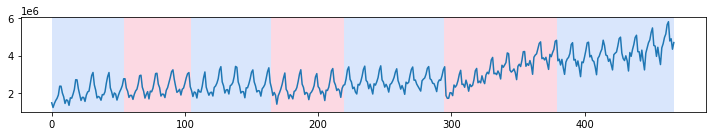

[55, 105, 165, 220, 295, 380, 468]

In [27]:
# min_size=50
lin_sig, change_points = get_changepoints(signal=sig, minimum_size=50)
change_points

Coefficient for 0 to 55 -> 10679.84098124099
Mean for 0 to 55 -> 2031991.5636363637
Growth for 0 to 55 -> 86.02912903303871

Coefficient for 55 to 105 -> 9598.223913565427
Mean for 55 to 105 -> 2326782.98
Growth for 55 to 105 -> -15.425199598511128

Coefficient for 105 to 165 -> 7305.539761044735
Mean for 105 to 165 -> 2415715.8333333335
Growth for 105 to 165 -> 20.369321554408863

Coefficient for 165 to 220 -> 5675.015007215012
Mean for 165 to 220 -> 2254063.2181818183
Growth for 165 to 220 -> 6.490530842449112

Coefficient for 220 to 295 -> 1436.0944523470835
Mean for 220 to 295 -> 2645666.2666666666
Growth for 220 to 295 -> 32.49691365949706

Coefficient for 295 to 380 -> 25151.236877076422
Mean for 295 to 380 -> 3226038.129411765
Growth for 295 to 380 -> 41.40960039379492

Coefficient for 380 to 468 -> 12702.236342502902
Mean for 380 to 468 -> 4143804.772727273
Growth for 380 to 468 -> 26.040807499513008



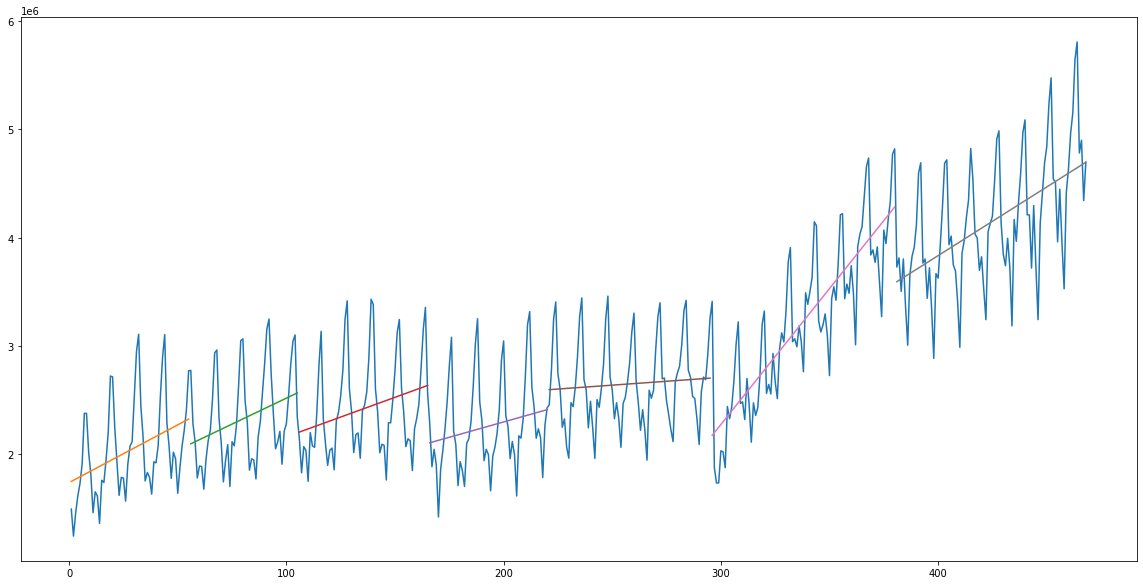

In [28]:
# Fitting regression lines between change points
plt.figure(figsize=(20,10))
plt.plot(lin_sig[:, 2], lin_sig[:, 0])

predi = {}
mse_ = {}
prev_change = 0
for i, each_change_point in enumerate(change_points):
    if prev_change == 0:
        pred, coef, mean, growth = regression_between_points(signal=lin_sig, lower_limit=prev_change, upper_limit=each_change_point)
        predi.update({f"pred{i}": pred})
        plt.plot(lin_sig[:each_change_point, 2], pred)
        print(f"Coefficient for {prev_change} to {each_change_point} -> {coef[1]}")
#         print(f"Angle for {prev_change} to {each_change_point} -> {np.arctan(coef)*180/np.pi}")
#         print(f"Intercept for {prev_change} to {each_change_point} -> {intercept}")
        print(f"Mean for {prev_change} to {each_change_point} -> {mean}")
        print(f"Growth for {prev_change} to {each_change_point} -> {growth}\n")
        prev_change = each_change_point
        
        
    else:
        pred, coef, mean, growth = regression_between_points(signal=lin_sig, lower_limit=prev_change, upper_limit=each_change_point)
        predi.update({f"pred{i}": pred})
        plt.plot(lin_sig[prev_change:each_change_point, 2], pred)
        print(f"Coefficient for {prev_change} to {each_change_point} -> {coef[1]}")
#         print(f"Angle for {prev_change} to {each_change_point} -> {np.arctan(coef)*180/np.pi}")
#         print(f"Intercept for {prev_change} to {each_change_point} -> {intercept}")
        print(f"Mean for {prev_change} to {each_change_point} -> {mean}")
        print(f"Growth for {prev_change} to {each_change_point} -> {growth}\n")
        prev_change = each_change_point
